In [1]:
import os
import pandas as pd
import sys
import datetime
import math
import time
#import folium

from vega import VegaLite

## Bus Bunching Detection

In [2]:
def readFiles(dataPath):
    dataFrames = []
    
    # Create one file by day of analysis
    for dirName in os.listdir(dataPath):
        allBusteData = []
        for fileName in os.listdir(dataPath + dirName):
            filePath = dataPath + dirName +  "/" + fileName
            if ("part-" in fileName):
                allBusteData.append(pd.read_csv(filePath))

         # Concatenate all data of one day into one DataFrame
        dataByDay = pd.concat(allBusteData, ignore_index = True)
        print("Day " + dataByDay['date'][0])
        print(dataByDay.head(5))
        dataFrames.append(dataByDay)

    #dataFrames.append(pd.read_csv(dataPath + "test")) # TODO just for test

    return dataFrames

In [3]:
def processingData(dataFrames):

    dataFramesFiltered = []
    
    for dataByDay in dataFrames:
        
        # Remove unusable columns
        dataByDay = dataByDay.drop(['shapeSequence', 'distanceTraveledShape', 'gpsPointId', 'distanceToShapePoint', 'stopPointId',
                                    'problem', 'birthdate', 'cardTimestamp', 'lineName', 'cardNum', 'gender'], axis=1)

        print("After filter columns: ", dataByDay.shape)

        # Removing data without gps point
        before = dataByDay.shape[0]
        dataByDay = dataByDay[dataByDay.gpsLat != "-"]
        print("After remove rows without GPS: ", dataByDay.shape)
        after = dataByDay.shape[0]
        deleted_rows = before - after
        print("Deleted rows", deleted_rows)

        # Fixing index by number of rows
        dataByDay = dataByDay.reset_index(drop = True)
        
        # Creating new column id to index rows
        dataByDay.insert(0, "id", dataByDay.index)

        # Creating new column time to group by timestamp and reduce comparisons
        dataByDay.insert(1, "time", dataByDay.timestamp.str[:4])
        
        # Convert timestamp to date
        dataByDay['date'] = dataByDay['date'].replace("_", "-", regex = True)
        dataByDay['timestamp'] = pd.to_datetime(dataByDay.date.astype(str) + ' ' + dataByDay.timestamp.astype(str))
        
        print("Processed data: ")
        print(dataByDay.head())
        
        dataFramesFiltered.append(dataByDay)
        
    return dataFramesFiltered

In [4]:
# Output dataframe to add Bus Bunching occurrence
def createOutputDataframe(dataByDay):
    outputBusBunching = dataByDay
    outputBusBunching['busBunching'] = "" # create new column

    return outputBusBunching

In [5]:
def distanceBetween(origin, destination):
    """
    Calculate the Haversine distance.

    Parameters
    ----------
    origin : tuple of float
        (lat, long)
    destination : tuple of float
        (lat, long)

    Returns
    -------
    distance_in_m : float

    Examples
    --------
    >>> origin = (48.1372, 11.5756)  # Munich
    >>> destination = (52.5186, 13.4083)  # Berlin
    >>> round(distance(origin, destination), 1)
    504.2
    """
    lat1, lon1 = origin
    lat2, lon2 = destination
    radius = 6371  # km

    dlat = math.radians(lat2 - lat1)
    dlon = math.radians(lon2 - lon1)
    a = (math.sin(dlat / 2) * math.sin(dlat / 2) +
         math.cos(math.radians(lat1)) * math.cos(math.radians(lat2)) *
         math.sin(dlon / 2) * math.sin(dlon / 2))
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    d = radius * c

    return d * 1000 #meters

In [6]:
def isBusBunching(distance, threshold):
    """
    Detecting Bus Bunching.

    Parameters
    ----------
    distance : distance between two gps points
        float

    Returns
    -------
    is_bus_bunching : boolean

    Examples
    --------
    >>> distance = 98.08
    true
    """
    return distance < threshold

In [7]:
def generateOutputBusBunchingDetection(dataByDay, dataByDayOutput, route_buses_dic, distanceThreshold, outputPath):

    outputBusBunching = dataByDayOutput
    
    for row in dataByDay.itertuples():
        """
        Index=0, id=0, time='05:4', route=463, tripNum=1, shapeId=2846, shapeLat=-25.478024708433903, 
        shapeLon=-49.203032595858183, busCode='DC090', gpsLat='-25.477931', gpsLon='-49.203043', 
        timestamp=Timestamp('2017-04-30 05:48:27'), date='2017-04-30', busBunching=''
        """
        indexFirstBus = row[1]
        timeFirstBus = row[2]
        routeFirstBus = row[3]
        shapeIdFirstBus = row[5]
        latitudeFirstBus = row[6]
        longitudeFirstBus = row[7]
        codeFirstBus = row[8]
        timestampFirstBus = row[11]

        closestTime = ""
        previousBus = ""

        # Compare buses from the same route and shape id (avoiding buses in opposite trips, e.g.)
        # and in time range (avoiding buses in different hours, e.g.)
        buses_same_route = route_buses_dic[routeFirstBus, timeFirstBus, shapeIdFirstBus]

        for rowOtherBus in buses_same_route:
            """
            [0, '05:4', 463, 1, 2846, -25.478024708433903, -49.20303259585818, 'DC090', '-25.477931', '-49.203043', 
            Timestamp('2017-04-30 05:48:27'), '2017-04-30']
            """
            indexOtherBus = rowOtherBus[0]
            routeOtherBus = rowOtherBus[2]
            codeOtherBus = rowOtherBus[7]
            timestampOtherBus = rowOtherBus[10]
            latitudeOtherBus = rowOtherBus[5]
            longitudeOtherBus = rowOtherBus[6]


            if (codeOtherBus != codeFirstBus): # avoiding to compare with the same bus
                difTime = abs(timestampOtherBus - timestampFirstBus)

                if (previousBus == codeOtherBus):

                    #find the nearest timestamps

                    if (difTime < closestTime):
                        closestTime = difTime
                        closestBusCode = codeOtherBus
                        closestLat = latitudeOtherBus
                        closestLon = longitudeOtherBus
                        closestID = indexOtherBus

                else:
                    #first, analyse the last bus

                    if (closestTime != "" ):
                        distance = distanceBetween((float(latitudeFirstBus), float(longitudeFirstBus)), 
                                                   (float(closestLat), float(closestLon)))

                        if (isBusBunching(distance, distanceThreshold)):
                            bbFirstBus = outputBusBunching.iloc[indexFirstBus]["busBunching"]
                            if (str(closestID) not in bbFirstBus):
                                outputBusBunching.loc[indexFirstBus,'busBunching'] = bbFirstBus + str(closestID) + "-"

                            bbClosestBus = outputBusBunching.iloc[closestID]["busBunching"]
                            if (str(indexFirstBus) not in bbClosestBus):
                                outputBusBunching.loc[closestID,'busBunching'] = bbClosestBus + str(indexFirstBus) + "-"

                    # -----------------------------------------
                    # New bus to compare: reseting variables
                    previousBus = codeOtherBus
                    closestTime = difTime
                    closestBusCode = codeOtherBus
                    closestLat = latitudeOtherBus
                    closestLon = longitudeOtherBus
                    closestID = indexOtherBus
    
    print("Output Bus Bunching " + outputBusBunching['date'][0])
    print(outputBusBunching.loc[outputBusBunching['busBunching'] != ""].head())
    saveToCSV(outputBusBunching, outputBusBunching["date"][0], outputPath)


In [8]:
# Saving csv file
def saveToCSV(outputByDay, date, outputPath):
    # to print bus bunching
    # outputBusBunching.loc[outputBusBunching['busBunching'] != ""]
    
    outputByDay.to_csv(outputPath + "outputBusBunching-" + date + ".csv", index_label = "index", encoding = 'utf-8')

In [9]:
def executeDetection(dataFramesFiltered, distanceThreshold, outputPath):
    
    for dataByDay in dataFramesFiltered:
        outputByDay = createOutputDataframe(dataByDay)
        
        # Mapping route - buses
        route_buses_dic = dataByDay.groupby(['route', 'time', 'shapeId']).apply(lambda f: f[["id", "time", "route", "tripNum", 
                                                                                             "shapeId", "shapeLat", "shapeLon", 
                                                                                             "busCode", "gpsLat", "gpsLon", 
                                                                                             "timestamp", 
                                                                                             "date"]].values.tolist()).to_dict()
        generateOutputBusBunchingDetection(dataByDay, outputByDay, route_buses_dic, distanceThreshold, outputPath)    

In [10]:
def main():
    start_time = time.time()
    
    DISTANCE_THRESHOLD = 100 # meters

    inputPath = os.getcwd() + "/data/buste/"
    outputPath = os.getcwd() + "/data/outputBusBunching/"
    
    dataFrames = readFiles(inputPath)
    dataFramesFiltered = processingData(dataFrames)
    
    executeDetection(dataFramesFiltered, DISTANCE_THRESHOLD, outputPath)
    
    executionTime = int(time.time() - start_time) / 60
    print("--- %s minutes ---" % executionTime)

In [11]:
if __name__ == '__main__':
    main()

C:\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2881: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Day 2017_04_30
   route tripNum  shapeId  shapeSequence   shapeLat   shapeLon  \
0    463       1     2846        6348468 -25.478025 -49.203033   
1    463       1     2846        6348493 -25.474027 -49.209193   
2    463       1     2846        6348516 -25.468650 -49.213528   
3    463       1     2846        6348531 -25.464090 -49.217170   
4    463       1     2846        6348545 -25.459453 -49.220872   

   distanceTraveledShape busCode gpsPointId      gpsLat     ...      \
0               1128.772   DC090          -  -25.477931     ...       
1               1899.853   DC090          -   -25.47397     ...       
2               2638.152   DC090          -           -     ...       
3               3262.176   DC090          -  -25.464081     ...       
4               3896.639   DC090          -           -     ...       

  distanceToShapePoint timestamp stopPointId     problem birthdate  \
0            10.472111  05:48:27       31707  NO_PROBLEM  18/10/63   
1             8.77226

## Validation

In [1]:
def plotMarkersOnMap(outputBusBunching):
    
    from IPython.display import HTML, display
    # Validating bus bunching at map

    # filter rows with bus bunching
    busBunching = outputBusBunching.loc[outputBusBunching["busBunching"].notnull()]

    # create dic route - color
    colors = {"orange", "blue", "brown", "pink", "black", "red", "green", "purple"} 
    busBunchingRoutes = busBunching.route.unique()
    print("Routes with BB: ", busBunchingRoutes)
    routeColorDict = dict(zip(busBunchingRoutes, colors))

    # Make an empty map
    m = folium.Map(tiles = "OpenStreetMap", zoom_start = 13, location = [-25.428777,-49.249120])

    # I can add marker one by one on the map
    for i in range(0, len(busBunching)):
        route = busBunching.iloc[i]['route']
        id = busBunching.iloc[i]['id']
        popup_data = "route: " + str(route) + " id: " + str(id) + " Bus Code: " + str(busBunching.iloc[i]['busCode']) + " Timestamp: " + str(busBunching.iloc[i]['timestamp']) + " BB: " + str(busBunching.iloc[i]['busBunching'])

        folium.CircleMarker([busBunching.iloc[i]['gpsLat'], busBunching.iloc[i]['gpsLon']], popup = popup_data, 
                            color = routeColorDict[route], radius = 10, fill_opacity = 0.9).add_to(m)

     # Save it as html
    m.save('bus_bunching_visualization.html')

    m

def validationOnMap():
    dayOfAnalysis = "2017-04-30.csv"
    filePath = os.getcwd() + "/data/outputBusBunching/outputBusBunching-" + dayOfAnalysis
    outputBusBunching = pd.read_csv(filePath)
    
    #print(outputBusBunching[outputBusBunching["busBunching"] != ""])
    
    plotMarkersOnMap(outputBusBunching)

In [2]:
if __name__ == '__main__':
    validationOnMap()

NameError: global name 'os' is not defined

## Analysis

### Por rota

Total de rotas: 201

**Com aglomerados: 8 rotas (4%)**

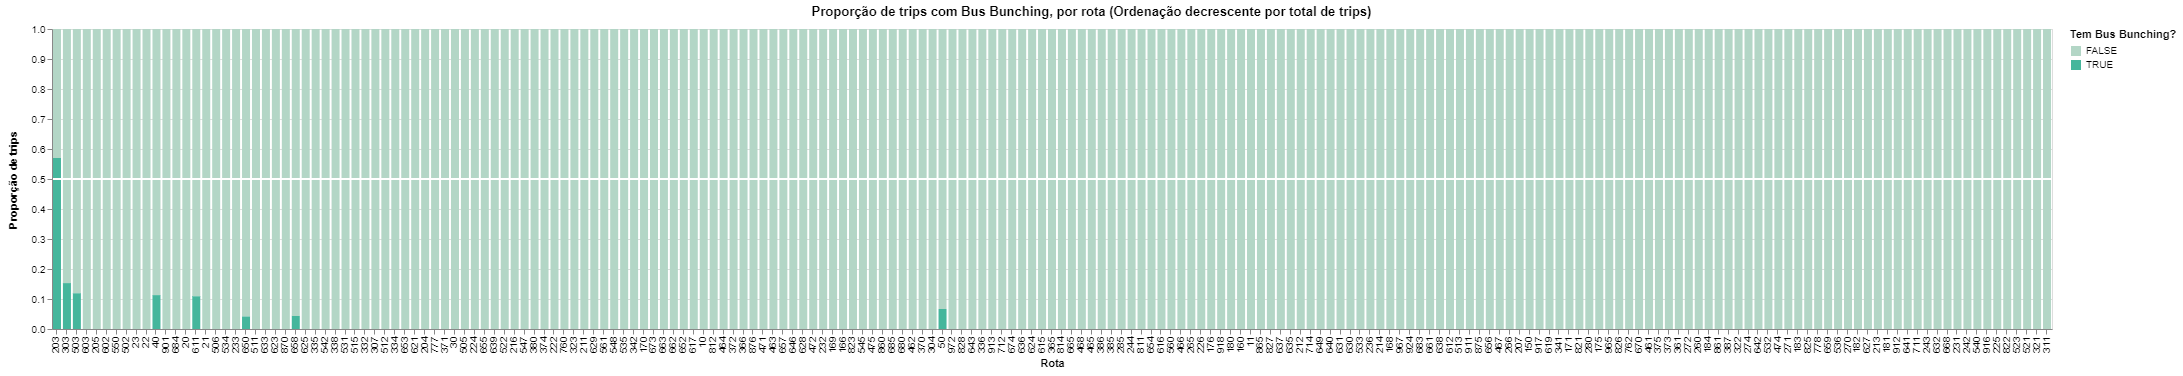

In [2]:
VegaLite({
  "$schema": "https://vega.github.io/schema/vega-lite/v2.json",
  "width": 2000,
  "height": 300,
  "title": {
    "text": "Proporção de trips com Bus Bunching, por rota (Ordenação decrescente por total de trips)"
  },
  "data": {
    "url": "https://gist.githubusercontent.com/veruskasantos/65e3b265d6ad8a4ca59427c8d2d9da34/raw/6c61f0a30b6d94703db7a64f10f08b8956d8c626/bb_per_route_curitiba.csv"
  },
  "transform": [
    {
      "calculate": "0.5",
      "as": "ref"
    }
  ],
  "layer": [
    {
      "mark": {
        "type": "bar",
        "size": 8
      },
      "encoding": {
        "x": {
          "field": "route",
          "type": "nominal",
          "axis": {
            "title": "Rota"
          },
          "sort": {
            "op": "sum",
            "field": "trips",
            "order": "descending"
          }
        },
        "color": {
          "field": "hasBusBunching",
          "type": "nominal","legend": {"title": "Tem Bus Bunching?"},
          "scale": {
            "range": [
              "#B3D6C6",
              "#45B69C"
            ]
          }
        },
        
        "y": {
          "field": "percTrips",
          "type": "quantitative",
          "stack": "normalize",
          "axis": {
            "title": "Proporção de trips"
          }
        },
        "tooltip": [
          {
            "field": "date",
            "type": "ordinal",
            "title": "Date"
          },
          {
            "field": "route",
            "type": "nominal",
            "title": "Route"
          },
          {
            "field": "hasBusBunching",
            "type": "nominal",
            "title": "Has BB?"
          },
          {
            "field": "trips",
            "type": "quantitative",
            "title": "Total trips"
          },
          {
            "field": "percTrips",
            "type": "quantitative",
            "title": "Trips %"
          }
        ]
      }
    },
    {
      "mark": "rule",
      "encoding": {
        "y": {
          "field": "ref",
          "type": "quantitative"
        },
        "color": {
          "value": "white"
        },
        "size": {
          "value": 2
        }
      }
    }
  ]
})

### Por ônibus

Total de ônibus: 415

**Com aglomerados: 39 ônibus (9%)**

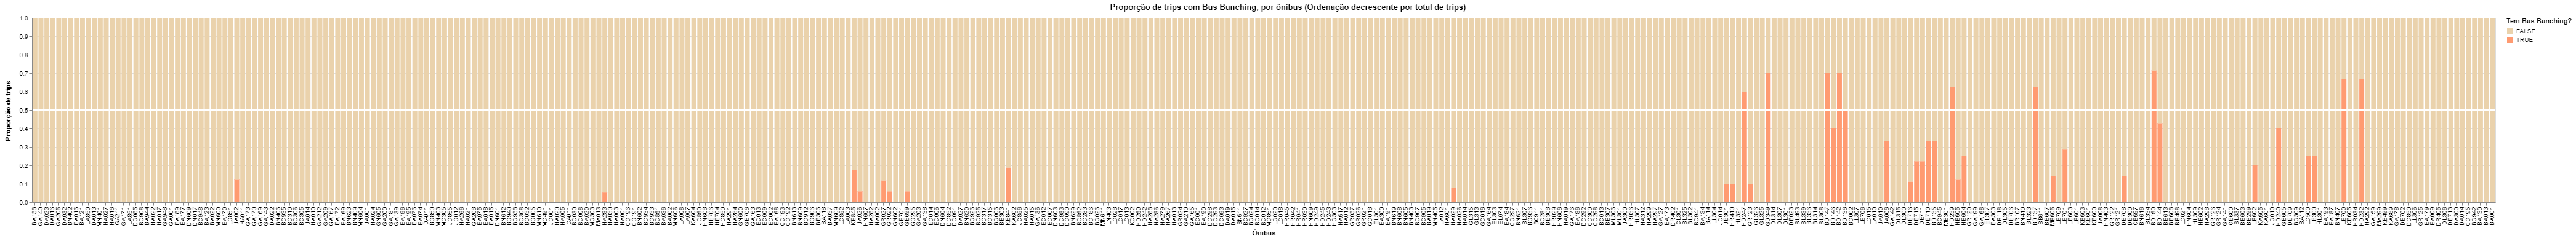

In [3]:
VegaLite(
{
  "$schema": "https://vega.github.io/schema/vega-lite/v2.json",
  "width": 4000,
  "height": 300,
  "title": {
    "text": "Proporção de trips com Bus Bunching, por ônibus (Ordenação decrescente por total de trips)"
  },
  "data": {
    "url": "https://gist.githubusercontent.com/veruskasantos/ed5136145c14c17e427243ae2925e62c/raw/fb0402134882a028ad65f3ccea864626d020d6f4/bb_per_bus_curitiba.csv"
  },
  "transform": [
    {
      "calculate": "0.5",
      "as": "ref"
    }
  ],
  "layer": [
    {
      "mark": {
        "type": "bar",
        "size": 8
      },
      "encoding": {
        "x": {
          "field": "busCode",
          "type": "nominal",
          "axis": {
            "title": "Ônibus"
          },
          "sort": {
            "op": "sum",
            "field": "trips",
            "order": "descending"
          }
        },
        "color": {
          "field": "hasBusBunching",
          "type": "nominal",
          "legend": {
            "title": "Tem Bus Bunching?"
          },
          "scale": {
            "range": [
              "#EAD2AC",
              "#FF9B71"
            ]
          }
        },
        "y": {
          "field": "percTrips",
          "type": "quantitative",
          "stack": "normalize",
          "axis": {
            "title": "Proporção de trips"
          }
        },
        "tooltip": [
          {
            "field": "date",
            "type": "ordinal",
            "title": "Date"
          },
          {
            "field": "busCode",
            "type": "nominal",
            "title": "Bus Code"
          },
          {
            "field": "hasBusBunching",
            "type": "nominal",
            "title": "Has BB?"
          },
          {
            "field": "trips",
            "type": "quantitative",
            "title": "Total trips"
          },
          {
            "field": "percTrips",
            "type": "quantitative",
            "title": "Trips %"
          }
        ]
      }
    },
    {
      "mark": "rule",
      "encoding": {
        "y": {
          "field": "ref",
          "type": "quantitative"
        },
        "color": {
          "value": "white"
        },
        "size": {
          "value": 2
        }
      }
    }
  ]
})